In [2]:
import math
from statsmodels.stats.power import TTestIndPower
import xlrd
import csv
import os
import os.path
import datetime as dt
import pandas as pd
import numpy as np
import xlsxwriter
from tabulate import tabulate
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pylab
from statsmodels.distributions.empirical_distribution import ECDF
import scipy.stats as st
import statistics
from pandas import DataFrame as df
import seaborn as sn
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Считываем файлы с тикерами

In [3]:
%%time
companies = {}
path = r'C:\kursovaya\companies'
for filename in os.listdir(path):
    with open(os.path.join(path, filename), "r") as file:
        companies[filename[:-4]] = [line.split(",") for line in file.read().splitlines()[1:]]

Wall time: 321 ms


### Таблица торговых дней

In [4]:
%%time
td_table = []
for company in companies:
    count = [0] * 6
    for day in companies[company]:
        count[int(day[0][3]) - 4] += 1
    count.insert(0, company)
    td_table.append(count)
m = np.array(td_table)
headers = ['Company name', '2014', '2015', '2016', '2017', '2018', '2019']
first_table = tabulate(m, headers, tablefmt="fancy_grid")
print(first_table)
td_table.insert(0, headers)
with xlsxwriter.Workbook('td.xlsx') as workbook:
    worksheet = workbook.add_worksheet()
    for row_num, data in enumerate(td_table):
        worksheet.write_row(row_num, 0, data)

╒════════════════╤════════╤════════╤════════╤════════╤════════╤════════╕
│ Company name   │   2014 │   2015 │   2016 │   2017 │   2018 │   2019 │
╞════════════════╪════════╪════════╪════════╪════════╪════════╪════════╡
│ AAPL           │    252 │    252 │    252 │    251 │    251 │    252 │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ ADBE           │    252 │    252 │    252 │    251 │    251 │    252 │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ AMZN           │    252 │    252 │    252 │    251 │    251 │    252 │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ EL             │    252 │    252 │    252 │    251 │    251 │    252 │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ FB             │    252 │    252 │    252 │    251 │    251 │    252 │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ MSFT           │    252 │    252 │    252 │    25

### Максимальные относительные скачки вверх и вниз

In [5]:
%%time
headers = ['Company name', '2014', '2015', '2016', '2017', '2018', '2019', 'Max.']
max_table = []
min_table = []
for company in companies:
    flact = {}
    min_diff = []
    max_diff = []
    for day in companies[company]:
        if day[0][:4] not in flact.keys():
            flact[day[0][:4]] = [float(day[-2])]
        else:
            flact[day[0][:4]].append(float(day[-2]))
    for year in flact:
        diff_list = []
        for x, y in zip(flact[year][0::], flact[year][1::]):
            diff_list.append(round((y - x) / x, 4))
        min_diff.append(min(diff_list))
        max_diff.append(max(diff_list))
    min_diff.append(min(min_diff))
    min_diff.insert(0, company)
    max_diff.append(max(max_diff))
    max_table.append(max_diff)
    max_diff.insert(0, company)
    min_table.append(min_diff)
print()
print("MAX FLACT")
m = np.array(max_table)
max_t = tabulate(m, headers, tablefmt="fancy_grid")
print(max_t)
print("MIN FLACT")
m = np.array(min_table)
min_t = tabulate(m, headers, tablefmt="fancy_grid")
print(min_t)


MAX FLACT
╒════════════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╕
│ Company name   │   2014 │   2015 │   2016 │   2017 │   2018 │   2019 │   Max. │
╞════════════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╡
│ AAPL           │ 0.082  │ 0.0574 │ 0.065  │ 0.061  │ 0.0704 │ 0.0683 │ 0.082  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ ADBE           │ 0.09   │ 0.0376 │ 0.0712 │ 0.1224 │ 0.0952 │ 0.0521 │ 0.1224 │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ AMZN           │ 0.0557 │ 0.1413 │ 0.0957 │ 0.1322 │ 0.0945 │ 0.0501 │ 0.1413 │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ EL             │ 0.0475 │ 0.0809 │ 0.0457 │ 0.0922 │ 0.07   │ 0.1252 │ 0.1252 │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ FB             │ 0.141  │ 0.0505 │ 0.1552 │ 0.0425 │ 0.0906 │ 0.1082 │ 0.1552 │
├────

### График компании NFLX

Wall time: 179 ms


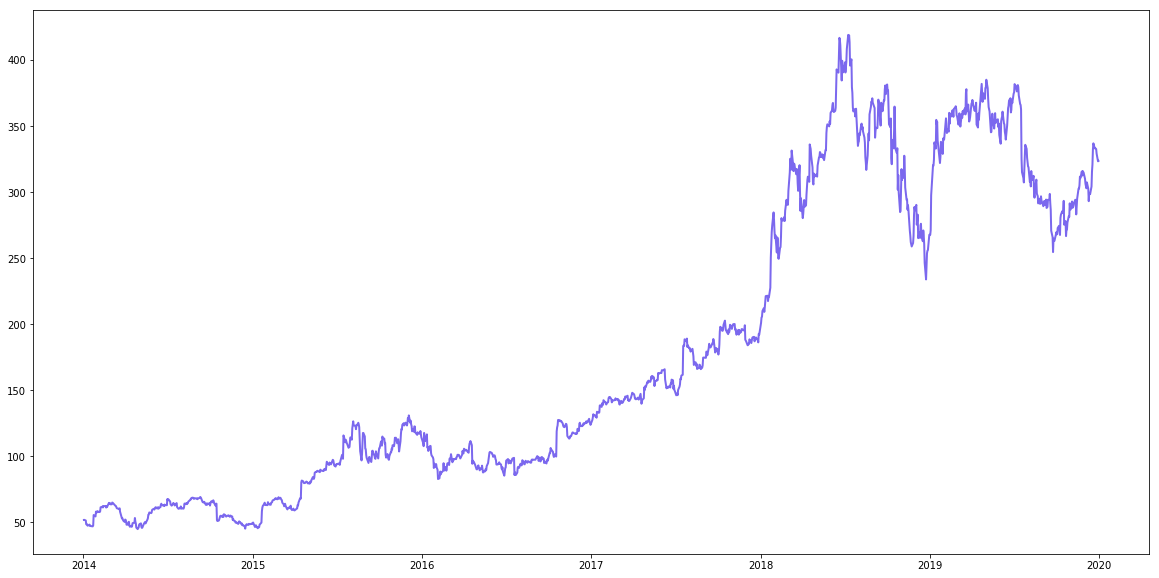

In [6]:
%%time
ydata = []
xdata = []

for x in companies["NFLX"]:
    ydata.append(float(x[-2]))
    year = int(x[0][0:4])
    if x[0][4:6].startswith("0"):
        month = int(x[0][6:7])
    else:
        month = int(x[0][5:7])
    if x[0][-2:].startswith("0"):
        day = int(x[0][-1])
    else:
        day = int(x[0][-2:])
    d = dt.datetime(year, month, day)
    xdata.append(d)
xdata_float = matplotlib.dates.date2num(xdata)
fig,ax = subplots(figsize = (20,10))
pylab.plot_date(xdata_float, ydata, fmt="b-",color = 'mediumslateblue', linewidth =2)  

### Отдельные квантили распределения статистики критерия Стьюдента

In [7]:
%%time
M = 10000
n = [252, 126, 63]
quantiles = []
for i in range(1, 1000):
    quantiles.append(i/1000)
t_stud = []
for k in n:
    tt = []
    pp = []
    quan = []
    for i in range(M):
        X = np.array(st.norm.rvs(size=k))
        Y = np.array(st.norm.rvs(size=k))
        Mx = statistics.mean(X)
        My = statistics.mean(Y)
        sum1 = 0
        sum2 = 0
        sum3 = 0
        for ind in range(len(X)):
            sum1 += (X[ind] - Mx) * (Y[ind] - My)
            sum2 += (X[ind] - Mx) ** 2
            sum3 += (Y[ind] - My) ** 2
        cor = sum1 / math.sqrt(sum2 * sum3)
        t = cor * ((k - 2) / (1 - (cor ** 2))) ** 0.5
        tt.append(t)
    for num in range(len(quantiles)):
        quan.append(round(np.quantile(np.array(tt), np.array(quantiles[num])), 3))
    t_stud.append(quan)
table = []
for i in range(len(t_stud[1])):
    list = [quantiles[i]]
    for period in t_stud:
        list.append(period[i])
    table.append(list)
final_table = []
for i in range(51):
    final_table.append(table[10 * i - 1])
final_table.pop(0)
headers = ["Levels", "Year", "Semester", "Quarter"]
m = np.array(final_table)
q_table = tabulate(m, headers, tablefmt="tsv")
print(q_table)
table.insert(0, headers)
with xlsxwriter.Workbook('quantiles.xlsx') as workbook:
    worksheet = workbook.add_worksheet()
    for row_num, data in enumerate(table):
        worksheet.write_row(row_num, 0, data)

  Levels	  Year	  Semester	  Quarter
    0.01	-2.351	    -2.338	   -2.36
    0.02	-2.084	    -2.056	   -2.072
    0.03	-1.927	    -1.893	   -1.912
    0.04	-1.794	    -1.756	   -1.781
    0.05	-1.696	    -1.652	   -1.676
    0.06	-1.613	    -1.546	   -1.586
    0.07	-1.524	    -1.48 	   -1.512
    0.08	-1.442	    -1.413	   -1.436
    0.09	-1.377	    -1.355	   -1.372
    0.1 	-1.32 	    -1.292	   -1.308
    0.11	-1.262	    -1.23 	   -1.245
    0.12	-1.204	    -1.183	   -1.193
    0.13	-1.152	    -1.138	   -1.143
    0.14	-1.107	    -1.095	   -1.101
    0.15	-1.061	    -1.046	   -1.056
    0.16	-1.022	    -0.997	   -1.014
    0.17	-0.981	    -0.957	   -0.979
    0.18	-0.941	    -0.915	   -0.939
    0.19	-0.899	    -0.872	   -0.9
    0.2 	-0.859	    -0.841	   -0.862
    0.21	-0.825	    -0.806	   -0.825
    0.22	-0.793	    -0.77 	   -0.79
    0.23	-0.757	    -0.74 	   -0.751
    0.24	-0.719	    -0.71 	   -0.718
    0.25	-0.691	    -0.682	   -0.683
    0.26	-0.66 	    -0.657	   -0.652
    0

### Гистограмма P-значений для модельных данных

0.523 < 1.36 => hypothesis accepted for α = 0.05


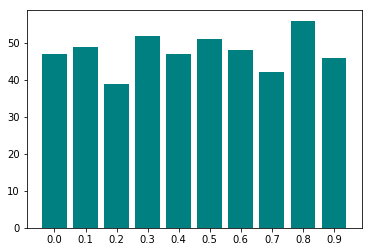

Wall time: 5.19 s


In [71]:
%%time
M = 1000
n = 252
q = []
wb = xlrd.open_workbook("quantiles.xlsx")
sheet = wb.sheet_by_index(0)
for i in range(sheet.nrows):
    q.append(sheet.cell_value(i, 1))
q.pop(0)
q = [float(i) for i in q]
p_values = []
tt = []
for i in range(M):
    X = np.array(st.norm.rvs(size=n))
    Y = np.array(st.norm.rvs(size=n))
    Mx = statistics.mean(X)
    My = statistics.mean(Y)
    sum1 = 0
    sum2 = 0
    sum3 = 0
    for ind in range(len(X)):
        sum1 += (X[ind] - Mx) * (Y[ind] - My)
        sum2 += (X[ind] - Mx) ** 2
        sum3 += (Y[ind] - My) ** 2
    cor = sum1 / math.sqrt(sum2 * sum3)
    t = cor * ((n - 2) / (1 - (cor ** 2))) ** 0.5
    tt.append(t)
for t in tt:
    p_values.append(2 * (1 - st.t.cdf(t, n-2, loc=0, scale=1)))
pp1 = sorted(p_values)
u_crit = 1.36
u = st.kstest(p_values, 'uniform', alternative="two-sided")[0]
if u < u_crit:
    print(str(u) + " < " + str(u_crit) + " => hypothesis accepted for α = 0.05")
if u > u_crit:
    print(str(u) + " < " + str(u_crit) + "=> hypothesis denied for α = 0.05")
xl = [i/100 for i in range(0, 100, 10)]
y = []
for i in xl:
    c = 0
    for j in pp1:
        if i <= j <= i + 0.1:
            c += 1
    y.append(c)
plt.bar(xl, y, 0.08, color='teal')
plt.xticks(xl)
plt.show()

### Оценка мощности критерия Стьюдента

In [17]:
%%time
M = 10000
n = [252, 126, 63]
q = [[], [], []]
p = [-0.1, 0.2]
wb = xlrd.open_workbook("quantiles.xlsx")
sheet = wb.sheet_by_index(0)
for i in range(sheet.nrows):
    q[0].append(sheet.cell_value(i, 1))
    q[1].append(sheet.cell_value(i, 2))
    q[2].append(sheet.cell_value(i, 3))
for i in q:
    i.pop(0)
    i = [float(l) for l in i]
t_cr = []
for i in q:
    t_cr.append(i[-25])
tt = []
for k in p:
    alt = [k, 0.05]
    for l in range(len(n)):
        count = 0
        for i in range(M):
            X = np.array(st.norm.rvs(size=n[l]))
            Z = np.array(st.norm.rvs(size=n[l]))
            Y = []
            for num in range(n[l]):
                Y.append(k * X[num] + Z[num] * (1 - k ** 2) ** 0.5)
            Y = np.array(Y)
            Mx = statistics.mean(X)
            My = statistics.mean(Y)
            sum1 = 0
            sum2 = 0
            sum3 = 0
            for ind in range(len(X)):
                sum1 += (X[ind] - Mx) * (Y[ind] - My)
                sum2 += (X[ind] - Mx) ** 2
                sum3 += (Y[ind] - My) ** 2
            cor = sum1 / math.sqrt(sum2 * sum3)
            t = cor * (((n[l] - 2) / (1 - (cor ** 2))) ** 0.5)
            if abs(t) > t_cr[l]:
                count += 1
        alt.append(round((count/M), 3))
    tt.append(alt)
headers = ["Correlation", "Significance level", "Year", "Semester", "Quarter"]
m = np.array(tt)
q_table = tabulate(m, headers, tablefmt="fancy_grid")
print(q_table)

╒═══════════════╤══════════════════════╤════════╤════════════╤═══════════╕
│   Correlation │   Significance level │   Year │   Semester │   Quarter │
╞═══════════════╪══════════════════════╪════════╪════════════╪═══════════╡
│          -0.1 │                 0.05 │  0.361 │      0.21  │     0.121 │
├───────────────┼──────────────────────┼────────┼────────────┼───────────┤
│           0.2 │                 0.05 │  0.896 │      0.622 │     0.352 │
╘═══════════════╧══════════════════════╧════════╧════════════╧═══════════╛
Wall time: 3min 39s


### Матрица коэффициентов корреляции

Wall time: 304 ms


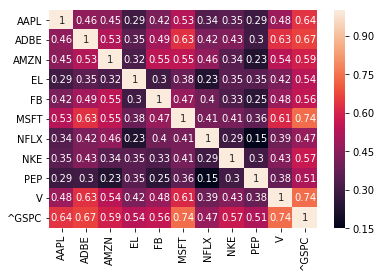

In [22]:
%%time
log_inc1 = {}
for com in companies:
    count=[]
    for i in range(1,1510):
        log = math.log(float(companies[com][i][-2]) / float(companies[com][i - 1][-2]), math.exp(1))
        year_digit = int(companies[com][i][0][3])
        count.append(log)
    log_inc1[com] = count
for key in log_inc1:
    if key not in headers:
        headers.append(key)
df = pd.DataFrame(log_inc1, columns=headers)
corrMatrix = df.corr() 
sn.heatmap(corrMatrix, annot=True)  

### P-значения реальных данных за год

In [54]:
%%time
log_inc = {}
for com in companies:
    count = [[], [], [], [], [], []]
    for i in range(1, len(companies[com])):
        log = math.log(float(companies[com][i][-2]) / float(companies[com][i - 1][-2]), math.exp(1))
        year_digit = int(companies[com][i][0][3])
        count[year_digit - 4].append(log)
    log_inc[com] = count
index = log_inc['^GSPC']
p_values = []
for com in log_inc:
    if com == '^GSPC':
        continue
    tt = []
    pv = []
    for i in range(len(log_inc[com])):
        X = np.array(log_inc[com][i][:250])
        Y = np.array(index[i][:250])
        n = len(X)
        Mx = statistics.mean(X)
        My = statistics.mean(Y)
        sum1 = 0
        sum2 = 0
        sum3 = 0
        for ind in range(len(X)):
            sum1 += (X[ind] - Mx) * (Y[ind] - My)
            sum2 += (X[ind] - Mx) ** 2
            sum3 += (Y[ind] - My) ** 2
        cor = sum1 / math.sqrt(sum2 * sum3)
        t = cor * ((n - 2) / (1 - (cor ** 2))) ** 0.5
        tt.append(t)
    for t in tt:
        pv.append(2 * (1 - st.t.cdf(t, 250, loc=0, scale=1)))
    pv.insert(0, com)
    p_values.append(pv)
headers = ["Company", "2014", "2015", "2016", "2017", "2018", "2019"]
if not os.path.isfile('year.xlsx'):
    p_values.insert(0, headers)
    with xlsxwriter.Workbook('year.xlsx') as workbook:
        worksheet = workbook.add_worksheet()
        for row_num, data in enumerate(p_values):
            worksheet.write_row(row_num, 0, data)
    p_values.pop(0)
m = np.array(p_values)
q_table = tabulate(m, headers, tablefmt="fancy_grid")
print(q_table)

╒═══════════╤═════════════╤═════════════╤═════════════╤═════════════╤═════════════╤═════════════╕
│ Company   │        2014 │        2015 │        2016 │        2017 │        2018 │        2019 │
╞═══════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ AAPL      │ 1.01896e-12 │ 0           │ 0           │ 0           │ 0           │ 0           │
├───────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│ ADBE      │ 0           │ 0           │ 0           │ 3.83866e-11 │ 0           │ 0           │
├───────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│ AMZN      │ 0           │ 0           │ 2.22045e-16 │ 4.02678e-12 │ 0           │ 0           │
├───────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│ EL        │ 0           │ 0           │ 0           │ 2.54857e-05 │ 0           │ 0           │
├───────────┼───────

### Гистограмма P-значений для реальных данных за год

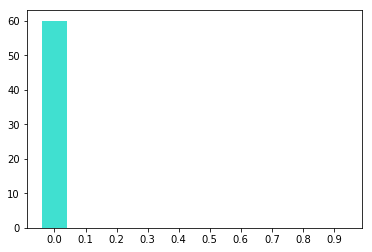

Wall time: 530 ms


In [39]:
%%time
p_values = [i[1:] for i in p_values]
p_v = []
for i in p_values:
    for j in i:
        p_v.append(j)
xl = [i/100 for i in range(0, 100, 10)]
y = []
pp1 = sorted(p_v)
for i in xl:
    c = 0
    for j in pp1:
        if i <= j <= i + 0.1:
            c += 1
    y.append(c)
plt.bar(xl, y, 0.08, color='turquoise')
plt.xticks(xl)
plt.show()

### Проверка для реальных данных за год

In [40]:
%%time
sl1 = 0.01
sl2 = 0.05
k1 = 0
k2 = 0
for value in p_v:
    if value > sl1:
        k1 += 1
    if value > sl2:
        k2 += 1
sign = [[round((k1 / len(p_v)), 3), round((k2 / len(p_v)), 3)]]
headers = ["1% sign. level", "5% sign. level"]
if not os.path.isfile('yearsign.xlsx'):
    sign.insert(0, headers)
    with xlsxwriter.Workbook('yearsign.xlsx') as workbook:
        worksheet = workbook.add_worksheet()
        for row_num, data in enumerate(sign):
            worksheet.write_row(row_num, 0, data)
m = np.array(sign)
q_table = tabulate(m, headers, tablefmt="fancy_grid")
print(q_table)

╒══════════════════╤══════════════════╕
│   1% sign. level │   5% sign. level │
╞══════════════════╪══════════════════╡
│                0 │                0 │
╘══════════════════╧══════════════════╛
Wall time: 3.81 ms


### Р-значения для реальных данных за второе полугодие

In [55]:
%%time
log_inc = {}
for com in companies:
    count = [[], [], [], [], [], []]
    for i in range(1, len(companies[com])):
        if int(companies[com][i][0][6]) >= 7 or int(companies[com][i][0][5]) == 1:
            log = math.log(float(companies[com][i][-2]) / float(companies[com][i - 1][-2]), math.exp(1))
            year_digit = int(companies[com][i][0][3])
            count[year_digit - 4].append(log)
    log_inc[com] = count
index = log_inc['^GSPC']
p_values = []
for com in log_inc:
    if com == '^GSPC':
        continue
    tt = []
    pv = []
    for i in range(len(log_inc[com])):
        X = np.array(log_inc[com][i][:126])
        Y = np.array(index[i][:126])
        n = len(X)
        Mx = statistics.mean(X)
        My = statistics.mean(Y)
        sum1 = 0
        sum2 = 0
        sum3 = 0
        for ind in range(len(X)):
            sum1 += (X[ind] - Mx) * (Y[ind] - My)
            sum2 += (X[ind] - Mx) ** 2
            sum3 += (Y[ind] - My) ** 2
        cor = sum1 / math.sqrt(sum2 * sum3)
        t = cor * ((n - 2) / (1 - (cor ** 2))) ** 0.5
        tt.append(t)
    for t in tt:
        pv.append(2 * (1 - st.t.cdf(t, 250, loc=0, scale=1)))
    pv.insert(0, com)
    p_values.append(pv)
headers = ["Company", "2014", "2015", "2016", "2017", "2018", "2019"]
p_values.pop(0)
m = np.array(p_values)
q_table = tabulate(m, headers, tablefmt="fancy_grid")
print(q_table)

╒═══════════╤═════════════╤════════════╤═════════════╤═════════════╤═════════════╤═════════════╕
│ Company   │        2014 │       2015 │        2016 │        2017 │        2018 │        2019 │
╞═══════════╪═════════════╪════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ AAPL      │ 4.88498e-15 │ 0          │ 9.28592e-06 │ 2.10527e-11 │ 0           │ 0           │
├───────────┼─────────────┼────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│ ADBE      │ 4.87158e-10 │ 0          │ 2.66454e-15 │ 3.07056e-05 │ 0           │ 0           │
├───────────┼─────────────┼────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│ AMZN      │ 1.40992e-07 │ 0          │ 5.2105e-12  │ 2.00715e-08 │ 0           │ 0           │
├───────────┼─────────────┼────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│ EL        │ 7.32747e-15 │ 0          │ 5.60741e-10 │ 0.0143571   │ 4.44089e-16 │ 1.26676e-12 │
├───────────┼─────────────┼───

### Гистограмма Р-значений для реальных данных за второе полугодие

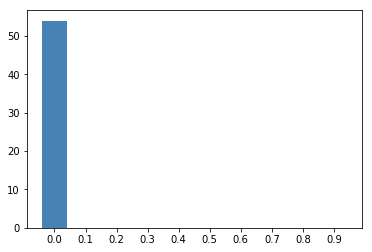

Wall time: 393 ms


In [45]:
%%time
p_values = [i[1:] for i in p_values]
p_v = []
for i in p_values:
    for j in i:
        p_v.append(j)
xl = [i/100 for i in range(0, 100, 10)]
y = []
pp1 = sorted(p_v)
for i in xl:
    c = 0
    for j in pp1:
        if i <= j <= i + 0.1:
            c += 1
    y.append(c)
plt.bar(xl, y, 0.08, color='steelblue')
plt.xticks(xl)
plt.show()

### Доля проверок для реальных данных за второе полугодие

In [43]:
%%time
sl1 = 0.01
sl2 = 0.05
k1 = 0
k2 = 0
for value in p_v:
    if value > sl1:
        k1 += 1
    if value > sl2:
        k2 += 1
sign = [[round((k1 / len(p_v)), 3), round((k2 / len(p_v)), 3)]]
headers = ["1% sign. level", "5% sign. level"]
m = np.array(sign)
q_table = tabulate(m, headers, tablefmt="fancy_grid")
print(q_table)

╒══════════════════╤══════════════════╕
│   1% sign. level │   5% sign. level │
╞══════════════════╪══════════════════╡
│            0.056 │                0 │
╘══════════════════╧══════════════════╛
Wall time: 1.08 ms


### Р-значения для реальных данных за четвертый квартал

In [56]:
%%time
log_inc = {}
for com in companies:
    count = [[], [], [], [], [], []]
    for i in range(1, len(companies[com])):
        if int(companies[com][i][0][6]) >= 9 or int(companies[com][i][0][5]) == 1:
            log = math.log(float(companies[com][i][-2]) / float(companies[com][i - 1][-2]), math.exp(1))
            year_digit = int(companies[com][i][0][3])
            count[year_digit - 4].append(log)
    log_inc[com] = count
index = log_inc['^GSPC']
p_values = []
for com in log_inc:
    if com == '^GSPC':
        continue
    tt = []
    pv = []
    for i in range(len(log_inc[com])):
        X = np.array(log_inc[com][i][:63])
        Y = np.array(index[i][:63])
        n = len(X)
        Mx = statistics.mean(X)
        My = statistics.mean(Y)
        sum1 = 0
        sum2 = 0
        sum3 = 0
        for ind in range(len(X)):
            sum1 += (X[ind] - Mx) * (Y[ind] - My)
            sum2 += (X[ind] - Mx) ** 2
            sum3 += (Y[ind] - My) ** 2
        cor = sum1 / math.sqrt(sum2 * sum3)
        t = cor * ((n - 2) / (1 - (cor ** 2))) ** 0.5
        tt.append(t)
    for t in tt:
        pv.append(2 * (1 - st.t.cdf(t, 250, loc=0, scale=1)))
    pv.insert(0, com)
    p_values.append(pv)
headers = ["Company", "2014", "2015", "2016", "2017", "2018", "2019"]
p_values.pop(0)
m = np.array(p_values)
q_table = tabulate(m, headers, tablefmt="fancy_grid")
print(q_table)

╒═══════════╤═════════════╤═════════════╤═════════════╤═════════════╤═════════════╤═════════════╕
│ Company   │        2014 │        2015 │        2016 │        2017 │        2018 │        2019 │
╞═══════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ AAPL      │ 3.30258e-06 │ 2.1401e-10  │ 0.000976147 │ 2.02473e-05 │ 0           │ 7.42295e-13 │
├───────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│ ADBE      │ 2.44249e-13 │ 9.87817e-09 │ 1.85526e-08 │ 0.0284976   │ 0           │ 8.80981e-07 │
├───────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│ AMZN      │ 0.000430509 │ 5.42455e-12 │ 4.60398e-08 │ 0.0001873   │ 0           │ 7.97504e-11 │
├───────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│ EL        │ 3.13597e-06 │ 6.00919e-12 │ 1.18582e-05 │ 0.281479    │ 8.88082e-07 │ 0.00117981  │
├───────────┼───────

### Доля проверок для реальных данных за четвёртый квартал

In [49]:
%%time
sl1 = 0.01
sl2 = 0.05
k1 = 0
k2 = 0
for value in p_v:
    if value > sl1:
        k1 += 1
    if value > sl2:
        k2 += 1
sign = [[round((k1 / len(p_v)), 3), round((k2 / len(p_v)), 3)]]
headers = ["1% sign. level", "5% sign. level"]
m = np.array(sign)
q_table = tabulate(m, headers, tablefmt="fancy_grid")
print(q_table)

╒══════════════════╤══════════════════╕
│   1% sign. level │   5% sign. level │
╞══════════════════╪══════════════════╡
│            0.056 │                0 │
╘══════════════════╧══════════════════╛
Wall time: 2.99 ms


### Гистограмма P-значений для реальных данных за четвёртый квартал

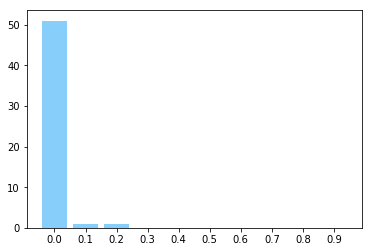

Wall time: 342 ms


In [50]:
%%time
p_values = [i[1:] for i in p_values]
p_v = []
for i in p_values:
    for j in i:
        p_v.append(j)
xl = [i/100 for i in range(0, 100, 10)]
y = []
pp1 = sorted(p_v)
for i in xl:
    c = 0
    for j in pp1:
        if i <= j <= i + 0.1:
            c += 1
    y.append(c)
plt.bar(xl, y, 0.08, color='lightskyblue')
plt.xticks(xl)
plt.show()

### Медианные P-значения по годам

In [51]:
%%time
wb = xlrd.open_workbook("year.xlsx")
sheet = wb.sheet_by_index(0)
q = []
for i in range(sheet.nrows):
    year = []
    for j in range(7):
        year.append(sheet.cell_value(i, j))
    year.pop(0)
    q.append(year)
q.pop(0)
year_medians = []
for i in range(6):
    year = []
    y = 2014+i
    for com in q:
        year.append(com[i])
    year_medians.append([y, statistics.median(year)])
headers = ["Year", "p-values"]
m = np.array(year_medians)
q_table = tabulate(m, headers, tablefmt="fancy_grid")
print(q_table)

╒════════╤════════════╕
│   Year │   p-values │
╞════════╪════════════╡
│   2014 │          0 │
├────────┼────────────┤
│   2015 │          0 │
├────────┼────────────┤
│   2016 │          0 │
├────────┼────────────┤
│   2017 │          0 │
├────────┼────────────┤
│   2018 │          0 │
├────────┼────────────┤
│   2019 │          0 │
╘════════╧════════════╛
Wall time: 57.8 ms


### Медианные P-значения по компаниям

In [52]:
%%time
wb = xlrd.open_workbook("year.xlsx")
sheet = wb.sheet_by_index(0)
q = []
for i in range(sheet.nrows):
    year = []
    for j in range(6):
        year.append(sheet.cell_value(i, j))
    q.append(year)
q.pop(0)
company_medians = []
for com in q:
    med = [com[0], statistics.median(com[1:])]
    company_medians.append(med)
headers = ["Company", "p-values"]
m = np.array(company_medians)
q_table = tabulate(m, headers, tablefmt="fancy_grid")
print(q_table)

╒═══════════╤════════════╕
│ Company   │   p-values │
╞═══════════╪════════════╡
│ AAPL      │          0 │
├───────────┼────────────┤
│ ADBE      │          0 │
├───────────┼────────────┤
│ AMZN      │          0 │
├───────────┼────────────┤
│ EL        │          0 │
├───────────┼────────────┤
│ FB        │          0 │
├───────────┼────────────┤
│ MSFT      │          0 │
├───────────┼────────────┤
│ NFLX      │          0 │
├───────────┼────────────┤
│ NKE       │          0 │
├───────────┼────────────┤
│ PEP       │          0 │
├───────────┼────────────┤
│ V         │          0 │
├───────────┼────────────┤
│ ^GSPC     │          0 │
╘═══════════╧════════════╛
Wall time: 19.9 ms
